# 🩺 Symptom-Disease Dataset Transformation and model training to predict diseases

This notebook transforms a medical dataset from a multi-label binary format into a two-column format containing:
1. Symptom Descriptions (both English and Swahili)
2. Associated Diseases (Prognosis)

It includes:
- Translation of symptoms from English to Swahili.
- Expansion of binary-encoded symptoms into individual records.
- Visualizations to better understand the final structure.

---


In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import joblib

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
# Setup for better visuals
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


## 📥 Load and Inspect Dataset

Let's start by loading the dataset that contains information about various symptoms and the diseases they are associated with.

Each row in this dataset represents a patient, and each column (except the last) shows whether the patient has a specific symptom (1 means "yes", 0 means "no"). The last column tells us the disease diagnosis (prognosis).


In [108]:
# Load dataset
df = pd.read_csv("Training.csv")

# Drop unnecessary columns
if 'Unnamed: 133' in df.columns:
    df.drop(columns=['Unnamed: 133'], inplace=True)

# Preview the first few rows
df.head()


,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


## 📊 Symptom Occurrence Distribution

Before transforming the dataset, it's helpful to see which symptoms appear most frequently.

This graph shows the 20 most common symptoms among all patients. It helps us understand what symptoms are most relevant in our dataset.


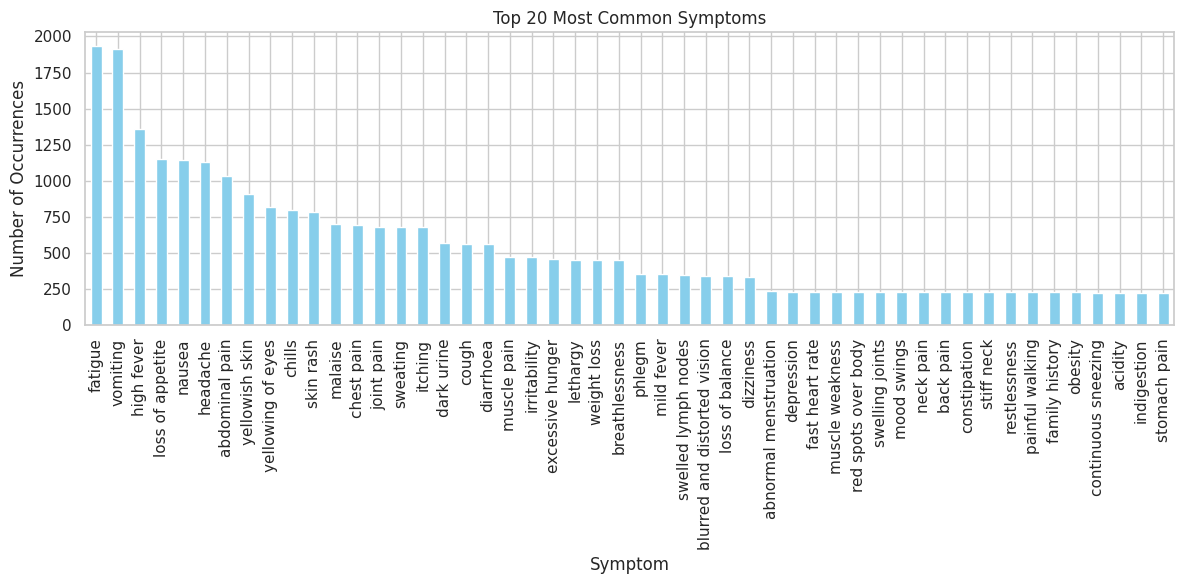

In [109]:
symptom_counts = df.drop(columns=["prognosis"]).sum().sort_values(ascending=False)
symptom_counts.index = symptom_counts.index.str.replace("_", " ")

# Plot top 20 symptoms
symptom_counts.head(50).plot(kind="bar", color="skyblue")
plt.title("Top 20 Most Common Symptoms")
plt.ylabel("Number of Occurrences")
plt.xlabel("Symptom")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## 🌐 Symptom Translation Dictionary

We are creating a dictionary to translate each symptom from English to Swahili.

This is important because we want our final dataset to support both English and Swahili users. The dictionary will allow us to add a translated Swahili version for every English symptom.


In [110]:

symptom_translation = {
    "itching": "muwasho",
    "skin rash": "upele",
    "nodal skin eruptions": "milipuko ya ngozi ya nodi",
    "continuous sneezing": "kupiga chafya mara kwa mara",
    "shivering": "kutetemeka",
    "chills": "baridi kali",
    "joint pain": "maumivu ya viungo",
    "stomach pain": "maumivu ya tumbo",
    "acidity": "kiwa",
    "ulcers on tongue": "vidonda kwenye ulimi",
    "muscle wasting": "kupungua kwa misuli",
    "vomiting": "kutapika",
    "burning micturition": "hisi ya moto wakati wa kukojoa",
    "spotting urination": "madoadoa kwenye mkojo",
    "fatigue": "uchovu",
    "weight gain": "ongezeko la uzito",
    "anxiety": "wasiwasi",
    "cold hands and feets": "mikono na miguu baridi",
    "mood swings": "mabadiliko ya hisia",
    "weight loss": "kupungua uzito",
    "restlessness": "kutotulia",
    "lethargy": "uchovu mwingi",
    "patches in throat": "madoa kwenye koo",
    "irregular sugar level": "kiwango kisicho sawa cha sukari",
    "cough": "kikohozi",
    "high fever": "homa kali",
    "sunken eyes": "macho yaliyodidimia",
    "breathlessness": "kukosa hewa",
    "sweating": "kutokwa jasho",
    "dehydration": "upungufu wa maji mwilini",
    "indigestion": "kusagika vibaya kwa chakula",
    "headache": "maumivu ya kichwa",
    "yellowish skin": "ngozi ya manjano",
    "dark urine": "mkojo mweusi",
    "nausea": "kichefuchefu",
    "loss of appetite": "kukosa hamu ya kula",
    "pain behind the eyes": "maumivu nyuma ya macho",
    "back pain": "maumivu ya mgongo",
    "constipation": "kukosa choo",
    "abdominal pain": "maumivu ya tumbo",
    "diarrhoea": "kuharisha",
    "mild fever": "homa ya kawaida",
    "yellow urine": "mkojo wa njano",
    "yellowing of eyes": "manjano kwenye macho",
    "acute liver failure": "kushindwa kwa ini kwa ghafla",
    "fluid overload": "kujaa kwa maji mwilini",
    "swelling of stomach": "uvimbe wa tumbo",
    "swelled lymph nodes": "uvimbe wa tezi za limfu",
    "malaise": "hali mbaya ya afya",
    "blurred and distorted vision": "maono yaliyopungua na yaliyopotoka",
    "phlegm": "makoo",
    "throat irritation": "mwasho kwenye koo",
    "redness of eyes": "macho mekundu",
    "sinus pressure": "shinikizo la sinus",
    "runny nose": "mafua",
    "congestion": "msongamano",
    "chest pain": "maumivu ya kifua",
    "weakness in limbs": "udhaifu wa viungo",
    "fast heart rate": "mapigo ya moyo ya haraka",
    "pain during bowel movements": "maumivu wakati wa haja kubwa",
    "pain in anal region": "maumivu katika sehemu ya haja kubwa",
    "bloody stool": "kinyesi chenye damu",
    "irritation in anus": "mwasho kwenye haja kubwa",
    "neck pain": "maumivu ya shingo",
    "dizziness": "kizunguzungu",
    "cramps": "mikakamao",
    "bruising": "michubuko",
    "obesity": "unene kupita kiasi",
    "swollen legs": "miguu iliyovimba",
    "swollen blood vessels": "mishipa ya damu iliyovimba",
    "puffy face and eyes": "uso na macho yenye uvimbe",
    "enlarged thyroid": "tezi dume iliyovimba",
    "brittle nails": "kucha dhaifu",
    "swollen extremeties": "viungo vilivyovimba",
    "excessive hunger": "njaa kupita kiasi",
    "extra marital contacts": "mahusiano nje ya ndoa",
    "drying and tingling lips": "midomo mikavu na hisi ya kuwashwa",
    "slurred speech": "matamshi yasiyoeleweka",
    "knee pain": "maumivu ya magoti",
    "hip joint pain": "maumivu ya nyonga",
    "muscle weakness": "udhaifu wa misuli",
    "stiff neck": "shingo ngumu",
    "swelling joints": "uvimbe kwenye viungo",
    "movement stiffness": "ukakamavu wa mwili",
    "spinning movements": "kuhisi dunia inazunguka",
    "loss of balance": "kupoteza mlingano",
    "unsteadiness": "kutotulia",
    "weakness of one body side": "udhaifu wa upande mmoja wa mwili",
    "loss of smell": "kupoteza uwezo wa kunusa",
    "bladder discomfort": "usumbufu wa kibofu",
    "foul smell of urine": "harufu mbaya ya mkojo",
    "continuous feel of urine": "hisia ya haja ndogo kila wakati",
    "passage of gases": "kupitisha gesi",
    "internal itching": "mwasho wa ndani",
    "toxic look (typhos)": "muonekano wa sumu (typhos)",
    "depression": "msongo wa mawazo",
    "irritability": "hasira za haraka",
    "muscle pain": "maumivu ya misuli",
    "altered sensorium": "mabadiliko ya ufahamu",
    "red spots over body": "madoadoa mekundu mwilini",
    "belly pain": "maumivu ya tumbo",
    "abnormal menstruation": "hedhi isiyo ya kawaida",
    "dischromic patches": "madoa ya rangi isiyo ya kawaida",
    "watering from eyes": "machozi kutoka machoni",
    "increased appetite": "kuongezeka kwa hamu ya kula",
    "polyuria": "mkojo mwingi",
    "family history": "historia ya familia",
    "mucoid sputum": "makoo yenye ute",
    "rusty sputum": "makoo yenye kutu",
    "lack of concentration": "ukosefu wa umakini",
    "visual disturbances": "usumbufu wa kuona",
    "receiving blood transfusion": "kupokea damu ya kuongezewa",
    "receiving unsterile injections": "kupokea sindano zisizo safi",
    "coma": "koma",
    "stomach bleeding": "kutokwa na damu tumboni",
    "distention of abdomen": "kuvimba kwa tumbo",
    "history of alcohol consumption": "historia ya unywaji pombe",
    "fluid overload.1": "kujaa kwa maji mwilini",
    "blood in sputum": "damu kwenye makoo",
    "prominent veins on calf": "mishipa inayoonekana kwenye ndama",
    "palpitations": "mapigo ya moyo yasiyo ya kawaida",
    "painful walking": "maumivu wakati wa kutembea",
    "pus filled pimples": "vipele vyenye usaha",
    "blackheads": "vipele vyeusi",
    "scurring": "kovu",
    "skin peeling": "ngozi inayochunika",
    "silver like dusting": "vumbi kama fedha",
    "small dents in nails": "mashimo madogo kwenye kucha",
    "inflammatory nails": "kucha zilizo na uchochezi",
    "blister": "malengelenge",
    "red sore around nose": "kidonda chekundu karibu na pua",
    "yellow crust ooze": "mafuta ya manjano yanayotoka"
}


## 🔁 Transform to Two-Column Format

The original dataset has many columns (one for each symptom). Now, we want to change this format.

We'll go through each patient record and:
- Identify all the symptoms marked as "1" (meaning the patient has that symptom).
- Create a new row for each of those symptoms, along with the disease.
- Add both the English and Swahili versions (if translation exists).

The result will be a long list where each row shows:
1. A symptom (in English or Swahili)
2. The disease it relates to

This format is easier for training AI models and helps with data analysis.


In [111]:
new_rows = []

for _, row in df.iterrows():
    disease = row["prognosis"]
    for col in df.columns[:-1]:  # Skip the last column "prognosis"
        if row[col] == 1:
            symptom_en = col.replace("_", " ")
            symptom_sw = symptom_translation.get(symptom_en)

            # English row
            new_rows.append({"description": symptom_en, "disease": disease})

            # Swahili row if available
            if symptom_sw:
                new_rows.append({"description": symptom_sw, "disease": disease})

# Create new DataFrame
final_df = pd.DataFrame(new_rows)
final_df.head(20)


,description,disease
0,itching,Fungal infection
1,muwasho,Fungal infection
2,skin rash,Fungal infection
3,upele,Fungal infection
4,nodal skin eruptions,Fungal infection
5,milipuko ya ngozi ya nodi,Fungal infection
6,dischromic patches,Fungal infection
7,skin rash,Fungal infection
8,upele,Fungal infection
9,nodal skin eruptions,Fungal infection


## 💾 Save and Explore Final Dataset

After transforming the dataset, we save it in a new file so it can be used later for AI training.

We also check:
- The total number of rows (how many symptom-disease pairs we created)
- How many unique symptoms are there (both English and Swahili)
- How many different diseases are covered

Finally, we display a few random rows from the new dataset to make sure everything looks correct.


In [112]:
# Save to CSV
final_df.to_csv("symptom_disease_dataset.csv", index=False)

# Summary
print("✅ Total Rows:", len(final_df))
print("✅ Unique Symptoms (English + Swahili):", final_df["description"].nunique())
print("✅ Unique Diseases:", final_df["disease"].nunique())

# Preview some rows
final_df.sample(10)


✅ Total Rows: 73080
✅ Unique Symptoms (English + Swahili): 257
✅ Unique Diseases: 41


,description,disease
47430,vomiting,(vertigo) Paroymsal Positional Vertigo
64535,kikohozi,Common Cold
47624,dizziness,Cervical spondylosis
72835,homa ya kawaida,Tuberculosis
29973,shingo ngumu,Migraine
61739,kutokwa jasho,Malaria
53966,increased appetite,Diabetes
59456,phlegm,Pneumonia
70628,mucoid sputum,Bronchial Asthma
70363,uchovu,Varicose veins


## 📈 Visualizing Top Symptoms and Diseases

Let's take a closer look at the final dataset.

We will make two charts:
1. The 15 most common symptoms (in both English and Swahili) and how often they appear.
2. The 10 most frequently diagnosed diseases.

These visualizations help us quickly understand the most important data points in our transformed dataset.


/tmp/ipykernel_70651/4118737586.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_symptoms.values, y=top_symptoms.index, palette="Blues_d")
/tmp/ipykernel_70651/4118737586.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_diseases.values, y=top_diseases.index, palette="Reds_d")


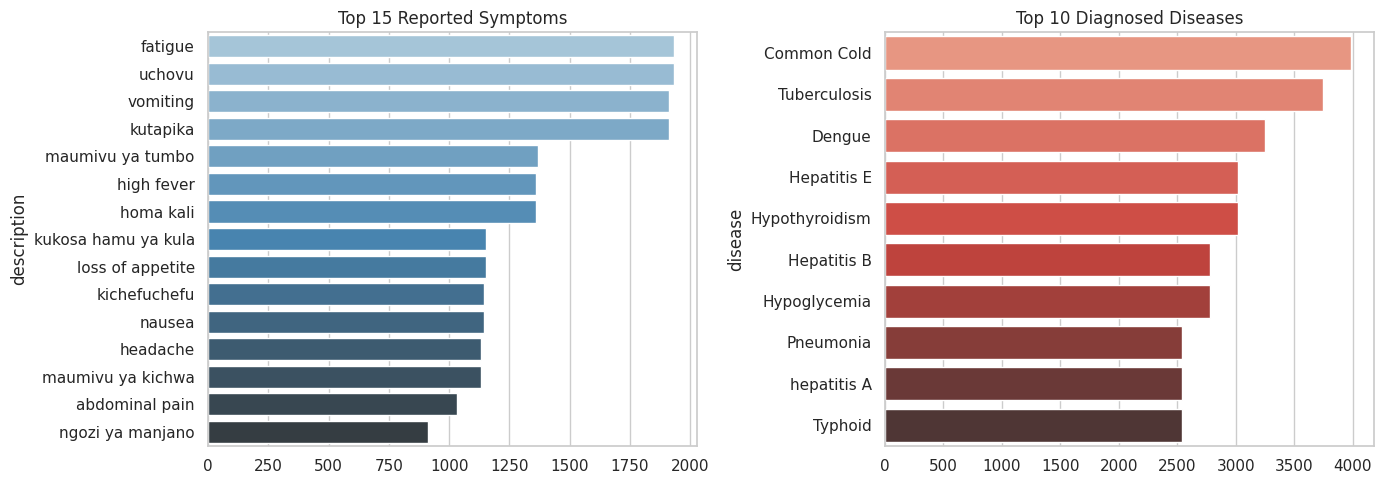

In [113]:
top_symptoms = final_df["description"].value_counts().head(15)
top_diseases = final_df["disease"].value_counts().head(10)

# Plot top symptoms
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=top_symptoms.values, y=top_symptoms.index, palette="Blues_d")
plt.title("Top 15 Reported Symptoms")

# Plot top diseases
plt.subplot(1, 2, 2)
sns.barplot(x=top_diseases.values, y=top_diseases.index, palette="Reds_d")
plt.title("Top 10 Diagnosed Diseases")

plt.tight_layout()
plt.show()


In [114]:
final_df["disease"].unique()

array(['Fungal infection', 'Allergy', 'GERD', 'Chronic cholestasis',
       'Drug Reaction', 'Peptic ulcer diseae', 'AIDS', 'Diabetes ',
       'Gastroenteritis', 'Bronchial Asthma', 'Hypertension ', 'Migraine',
       'Cervical spondylosis', 'Paralysis (brain hemorrhage)', 'Jaundice',
       'Malaria', 'Chicken pox', 'Dengue', 'Typhoid', 'hepatitis A',
       'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E',
       'Alcoholic hepatitis', 'Tuberculosis', 'Common Cold', 'Pneumonia',
       'Dimorphic hemmorhoids(piles)', 'Heart attack', 'Varicose veins',
       'Hypothyroidism', 'Hyperthyroidism', 'Hypoglycemia',
       'Osteoarthristis', 'Arthritis',
       '(vertigo) Paroymsal  Positional Vertigo', 'Acne',
       'Urinary tract infection', 'Psoriasis', 'Impetigo'], dtype=object)

## 🎯 Filter for Specific Diseases: Malaria, Typhoid, and Urinary Tract Infection (UTI)

From the full dataset, we are only interested in three diseases for now:
- **Malaria**
- **Typhoid**
- **Urinary tract infection**

We'll extract all rows that contain only these diseases.  
Also, for easier reference and medical abbreviation, we'll rename **"Urinary tract infection"** to **"(UTI)"** in our dataset.


In [115]:
# Define the target diseases
target_diseases = ['Malaria', 'Typhoid', 'Urinary tract infection']

# Filter rows with only these diseases
filtered_df = final_df[final_df['disease'].isin(target_diseases)].copy()

# Rename 'Urinary tract infection' to '(UTI)'
filtered_df['disease'] = filtered_df['disease'].replace('Urinary tract infection', 'UTI')

# Display a sample
filtered_df.head(5)


,description,disease
1488,chills,Malaria
1489,baridi kali,Malaria
1490,vomiting,Malaria
1491,kutapika,Malaria
1492,high fever,Malaria


## 📊 Disease Distribution: Malaria, Typhoid, and (UTI)

This chart shows how many symptom entries are associated with each of the selected diseases.

It helps us understand which disease has the most symptom records in our filtered data.


/tmp/ipykernel_70651/3546833002.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.index, y=disease_counts.values, palette="Set2")
/tmp/ipykernel_70651/3546833002.py:11: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/tarxemo/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


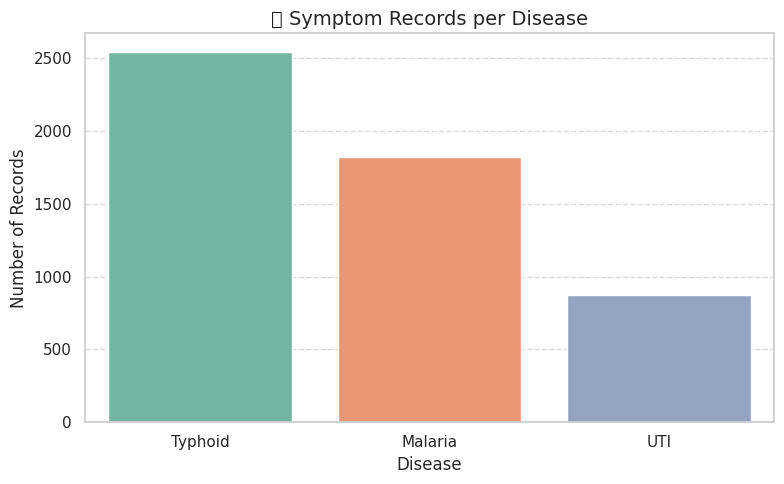

In [116]:
# Count disease occurrences
disease_counts = filtered_df['disease'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=disease_counts.index, y=disease_counts.values, palette="Set2")
plt.title("📌 Symptom Records per Disease", fontsize=14)
plt.xlabel("Disease", fontsize=12)
plt.ylabel("Number of Records", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [117]:
# Verify data
print(f"Original dataset size: {len(filtered_df)}")
print("Sample data:")
filtered_df.head()

Original dataset size: 5244
Sample data:


,description,disease
1488,chills,Malaria
1489,baridi kali,Malaria
1490,vomiting,Malaria
1491,kutapika,Malaria
1492,high fever,Malaria


### 🧪 Step 2: Data Augmentation
We augment the dataset with Swahili spelling variations to increase robustness. This step helps the model generalize better with noisy or inconsistent inputs.


In [118]:
import random
import re
from functools import reduce

def swahili_spelling_variation(word):
    """Generate common spelling variations for a Swahili word"""
    variations = [word]
    
    # Common Swahili character-level transformations
    transformations = [
        # Vowel substitutions
        lambda s: s.replace('a', random.choice(['aa', 'e', '']), 1) if 'a' in s else s,
        lambda s: s.replace('e', random.choice(['i', 'a', 'ie']), 1) if 'e' in s else s,
        lambda s: s.replace('i', random.choice(['e', 'ee', 'y']), 1) if 'i' in s else s,
        lambda s: s.replace('u', random.choice(['oo', 'w', 'uu']), 1) if 'u' in s else s,
        lambda s: s.replace('o', random.choice(['a', 'ou', 'oo']), 1) if 'o' in s else s,
        
        # Consonant substitutions
        lambda s: s.replace('k', random.choice(['c', 'ch', '']), 1) if 'k' in s else s,
        lambda s: s.replace('ch', random.choice(['sh', 'c', 'ky']), 1) if 'ch' in s else s,
        lambda s: s.replace('sh', random.choice(['ch', 's', 'sy']), 1) if 'sh' in s else s,
        lambda s: s.replace('m', random.choice(['n', 'mb', 'mm']), 1) if 'm' in s else s,
        lambda s: s.replace('n', random.choice(['m', 'ny', 'nn']), 1) if 'n' in s else s,
        lambda s: s.replace('b', random.choice(['p', 'v', 'bh']), 1) if 'b' in s else s,
        lambda s: s.replace('p', random.choice(['b', 'ph', '']), 1) if 'p' in s else s,
        lambda s: s.replace('v', random.choice(['b', 'f', 'vh']), 1) if 'v' in s else s,
        lambda s: s.replace('f', random.choice(['v', 'p', 'ph']), 1) if 'f' in s else s,
        lambda s: s.replace('d', random.choice(['t', 'dh', '']), 1) if 'd' in s else s,
        lambda s: s.replace('t', random.choice(['d', 'th', '']), 1) if 't' in s else s,
        
        # Common Swahili-specific transformations
        lambda s: s.replace('ny', random.choice(['n', 'ni', 'gn']), 1) if 'ny' in s else s,
        lambda s: s.replace('ng', random.choice(['n', 'g', 'nk']), 1) if 'ng' in s else s,
        lambda s: s.replace('gh', random.choice(['g', 'h', '']), 1) if 'gh' in s else s,
        lambda s: s.replace('th', random.choice(['t', 's', '']), 1) if 'th' in s else s,
        lambda s: s.replace('dh', random.choice(['d', 'z', '']), 1) if 'dh' in s else s,
        
        # Common Swahili prefix transformations
        lambda s: re.sub(r'^(ni)(\w+)', lambda m: random.choice(['n', 'mi', 'm'])+m.group(2), s) 
                  if s.startswith('ni') else s,
        lambda s: re.sub(r'^(na)(\w+)', lambda m: random.choice(['n', 'a', 'ma'])+m.group(2), s) 
                  if s.startswith('na') else s,
        lambda s: re.sub(r'^(ku)(\w+)', lambda m: random.choice(['kw', 'ko', 'k'])+m.group(2), s) 
                  if s.startswith('ku') else s,
        lambda s: re.sub(r'^(ki)(\w+)', lambda m: random.choice(['ch', 'ky', 'c'])+m.group(2), s) 
                  if s.startswith('ki') else s,
        lambda s: re.sub(r'^(vi)(\w+)', lambda m: random.choice(['vy', 'v', 'fi'])+m.group(2), s) 
                  if s.startswith('vi') else s,
        
        # Random mutations
        lambda s: s[:random.randint(1, len(s))] + random.choice(['a', 'e', 'i', 'o', 'u']) + s[random.randint(1, len(s)):] 
                  if len(s) > 3 else s,
        lambda s: s[:random.randint(1, len(s)-1)] + s[random.randint(1, len(s)-1)+1:] 
                  if len(s) > 3 else s,
        lambda s: s[:random.randint(1, len(s)-1)] + random.choice(['h', 'm', 'n']) + s[random.randint(1, len(s)-1):] 
                  if len(s) > 3 else s,
    ]
    
    # Apply transformations randomly
    for _ in range(random.randint(1, 3)):  # Apply 1-3 transformations
        if random.random() < 0.7:  # 70% chance to apply a transformation
            transform = random.choice(transformations)
            new_variant = transform(word)
            if new_variant != word:
                variations.append(new_variant)
    
    return list(set(variations))  # Remove duplicates

def augment_text(text, num_variations=5):
    """Generate augmented versions of a text"""
    words = text.split()
    augmented_texts = [text]  # Start with original text
    
    for _ in range(num_variations):
        new_words = []
        for word in words:
            # Get variations for each word
            word_variations = swahili_spelling_variation(word)
            # Choose one variation randomly
            new_words.append(random.choice(word_variations))
        
        # Combine words to form new text
        new_text = ' '.join(new_words)
        if new_text != text:
            augmented_texts.append(new_text)
    
    return list(set(augmented_texts))  # Remove duplicates


In [119]:
def augment_dataset(df, variations_per_sample=500):
    """Create augmented dataset with automatic spelling variations"""
    augmented_data = []
    
    for _, row in df.iterrows():
        original_text = row['description']
        variations = augment_text(original_text, variations_per_sample)
        
        for text in variations:
            augmented_data.append({
                'description': text,
                'disease': row['disease'],
                'is_original': (text == original_text)
            })
    
    return pd.DataFrame(augmented_data)

# Create augmented dataset
augmented_df = augment_dataset(filtered_df, variations_per_sample=10)

augumented_path = 'augmented.csv'
augmented_df.to_csv(augumented_path)

print(f"Original dataset size: {len(filtered_df)}")
print(f"Augmented dataset size: {len(augmented_df)}")
print(f"Number of variations per sample: {len(augmented_df)/len(filtered_df):.1f}x")

Original dataset size: 5244
Augmented dataset size: 18619
Number of variations per sample: 3.6x


### 📊 Step 3: Visualization of Data Augmentation
The chart shows how each disease category was augmented with spelling variations. Augmented samples significantly boost dataset size.


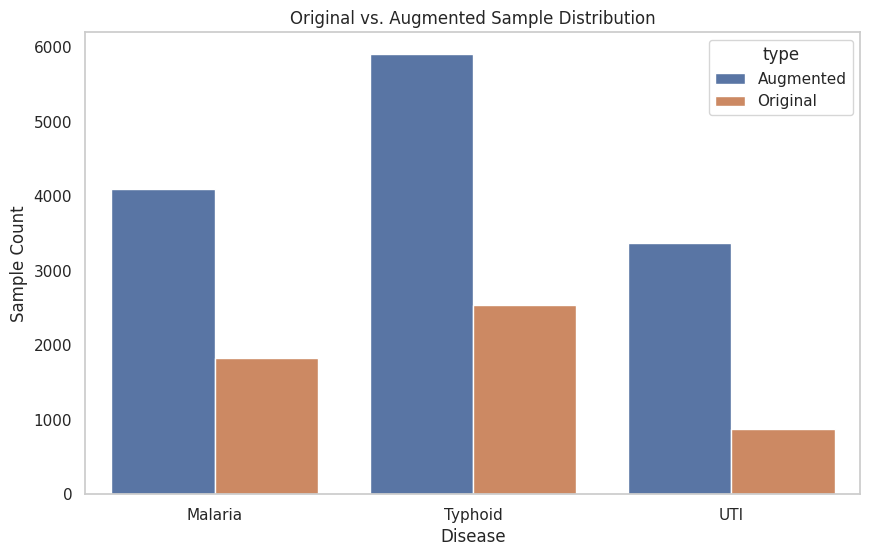

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count original vs. augmented
augmented_df['type'] = augmented_df['is_original'].apply(lambda x: 'Original' if x else 'Augmented')

plt.figure(figsize=(10, 6))
sns.countplot(data=augmented_df, x='disease', hue='type')
plt.title('Original vs. Augmented Sample Distribution')
plt.xlabel('Disease')
plt.ylabel('Sample Count')
plt.grid(axis='y')
plt.show()


### ✂️ Step 4: Syllable Tokenization
Swahili is syllabic. Instead of using word or character-level tokenization, we use **custom syllable tokenization** to better represent the language structure.


In [121]:
import re

def syllable_tokenizer(text):
    vowels = "aeiou"
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation
    words = text.split()
    syllables = []

    for word in words:
        i = 0
        w_len = len(word)
        word_syllables = []
        while i < w_len:
            # If it's a vowel, it's a syllable
            if word[i] in vowels:
                if i + 1 < w_len and word[i + 1] in vowels:
                    word_syllables.append(word[i])
                    i += 1
                else:
                    word_syllables.append(word[i])
                    i += 1
                continue

            # Consonant + Vowel
            if i + 1 < w_len and word[i+1] in vowels:
                # Check for a nasal+consonant like 'mw', 'ny'
                if word[i:i+2] in ['mw', 'ny', 'ng', 'nd', 'mb', 'nj', 'sy', 'sh']:
                    if i + 2 < w_len and word[i+2] in vowels:
                        word_syllables.append(word[i:i+3])
                        i += 3
                        continue
                word_syllables.append(word[i:i+2])
                i += 2
                continue

            # Consonant + Vowel + Consonant (like mwa)
            if i + 2 < w_len and word[i+1] in vowels and word[i+2] not in vowels:
                word_syllables.append(word[i:i+3])
                i += 3
                continue

            # Default to one letter (backup case)
            word_syllables.append(word[i])
            i += 1

        syllables.extend(word_syllables)

    return syllables


In [122]:
test_text = "naumwa kichwa na ninahisi kichwani"
print("\n🔤 Example Syllable Tokenization:")
print("Input:", test_text)
print("Output:", syllable_tokenizer(test_text))
test_text = "naumwa kichwa na ninahisi kichwani"
print("\nImproved Syllable tokenization:")
print(test_text)
print("→", syllable_tokenizer(test_text))
vectorizer = TfidfVectorizer(
    tokenizer=syllable_tokenizer,
    lowercase=True
)


🔤 Example Syllable Tokenization:
Input: naumwa kichwa na ninahisi kichwani
Output: ['na', 'u', 'm', 'wa', 'ki', 'c', 'h', 'wa', 'na', 'ni', 'na', 'hi', 'si', 'ki', 'c', 'h', 'wa', 'ni']

Improved Syllable tokenization:
naumwa kichwa na ninahisi kichwani
→ ['na', 'u', 'm', 'wa', 'ki', 'c', 'h', 'wa', 'na', 'ni', 'na', 'hi', 'si', 'ki', 'c', 'h', 'wa', 'ni']


### ✂️ Step 6: Dataset Splitting
We split the TF-IDF vectorized dataset into 80% training and 20% testing, ensuring class stratification is preserved.


In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Split augmented data
X = augmented_df['description']
y = augmented_df['disease']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)


print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


Training samples: 14895
Test samples: 3724


### 📈 Step 7: Visualize Training Class Distribution
We validate that class proportions are consistent in the training data.


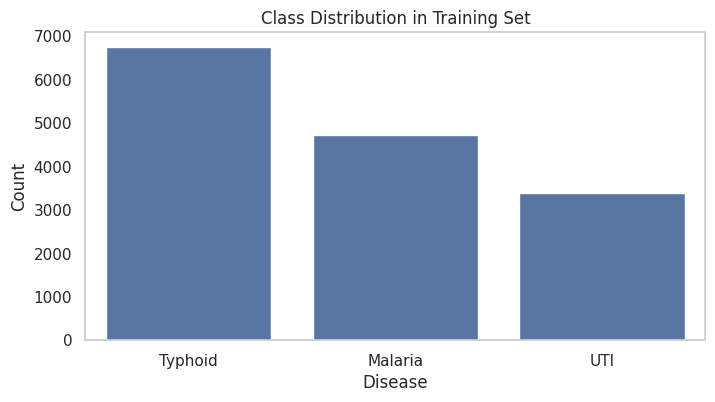

In [124]:
# Plot class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set")
plt.xlabel("Disease")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()


## ⚙️ Step 2: Define Pipelines for Multiple Classifiers
We will use the following models:
- Support Vector Machine (SVM)
- Naive Bayes
- Logistic Regression
- Random Forest
- K-Nearest Neighbors


In [125]:
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    'SVM': CalibratedClassifierCV(LinearSVC(class_weight='balanced', random_state=42)),
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier()
}

pipelines = {
    name: Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', model)
    ]) for name, model in models.items()
}


## 🔍 Step 3: Train and Evaluate All Models
We compute:
- Accuracy
- Precision
- Recall
- F1 Score
- Classification Report


In [126]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

results = {}

for name, pipeline in pipelines.items():
    print(f"\n🔧 Training {name}...")
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {
        'model': pipeline,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'y_pred': y_pred
    }
    
    print(f"✅ {name} Classification Report:\n{classification_report(y_test, y_pred)}")



🔧 Training SVM...
✅ SVM Classification Report:
              precision    recall  f1-score   support

     Malaria       0.62      0.61      0.62      1185
     Typhoid       0.73      0.73      0.73      1689
         UTI       1.00      1.00      1.00       850

    accuracy                           0.76      3724
   macro avg       0.78      0.78      0.78      3724
weighted avg       0.76      0.76      0.76      3724


🔧 Training Naive Bayes...
✅ Naive Bayes Classification Report:
              precision    recall  f1-score   support

     Malaria       0.66      0.52      0.58      1185
     Typhoid       0.71      0.81      0.76      1689
         UTI       1.00      1.00      1.00       850

    accuracy                           0.76      3724
   macro avg       0.79      0.78      0.78      3724
weighted avg       0.76      0.76      0.76      3724


🔧 Training Logistic Regression...
✅ Logistic Regression Classification Report:
              precision    recall  f1-score   

## 📊 Step 4: Visualize Confusion Matrix for Each Model
This helps us understand where each model is making mistakes.


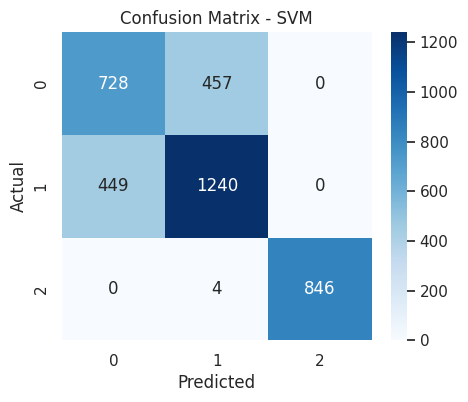

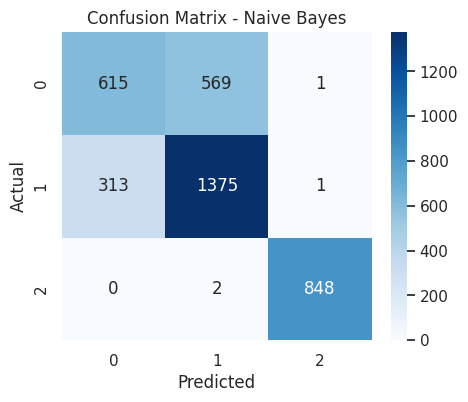

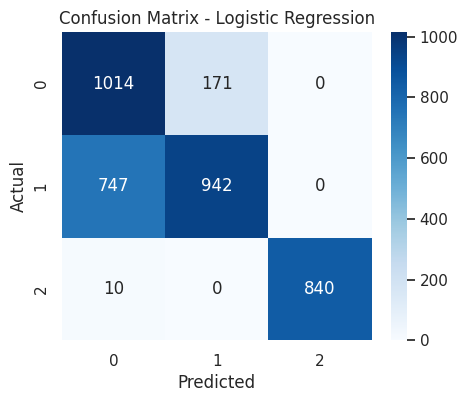

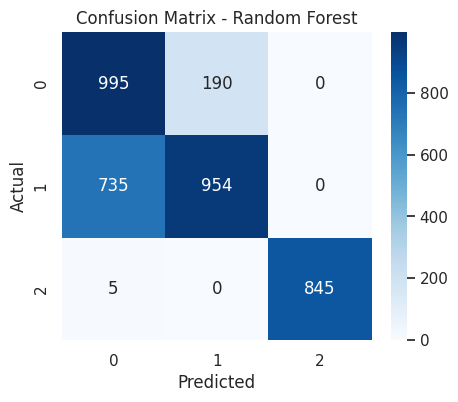

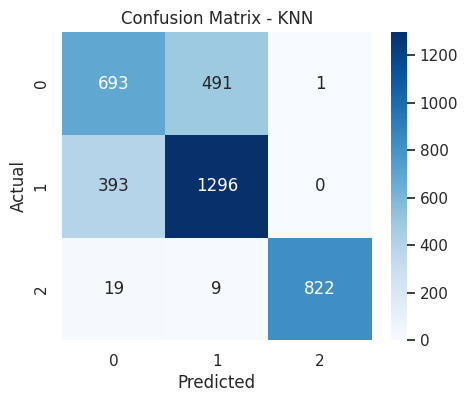

In [127]:
def plot_confusion(name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

for name, data in results.items():
    plot_confusion(name, y_test, data['y_pred'])


## 📈 Step 5: Compare All Models on Metrics
We compare Accuracy, Precision, Recall, and F1-score across all models using a grouped bar chart.


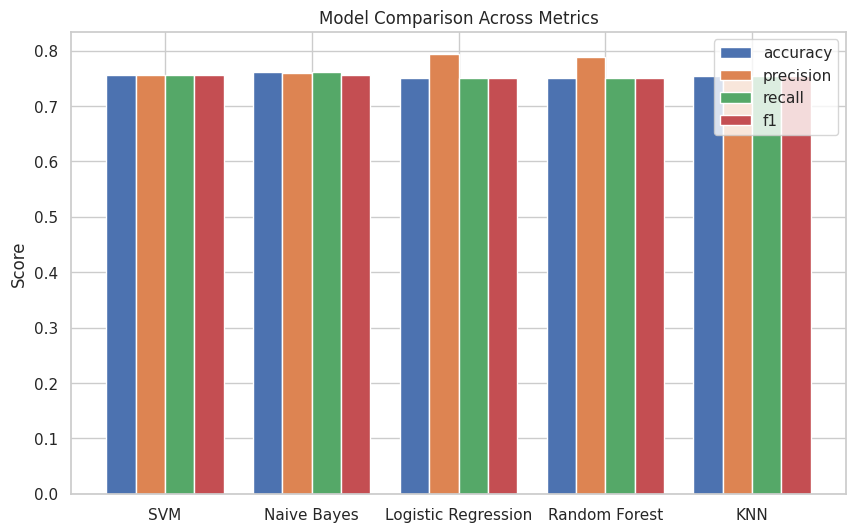

In [128]:
# Bar plot of metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']
metric_data = {m: [results[name][m] for name in results] for m in metrics}

x = np.arange(len(results))
width = 0.2

plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    plt.bar(x + i * width, metric_data[metric], width, label=metric)

plt.xticks(x + width * 1.5, results.keys())
plt.ylabel("Score")
plt.title("Model Comparison Across Metrics")
plt.legend()
plt.show()


## 🏆 Step 6: Select the Best Model
We choose the model with the highest **F1-score**, which balances precision and recall.


In [129]:
# Sort models by F1-score
sorted_models = sorted(results.items(), key=lambda x: x[1]['f1'], reverse=True)
best_model_name = sorted_models[0][0]
best_model = sorted_models[0][1]['model']

print(f"\n🏅 Best Model: {best_model_name}")



🏅 Best Model: Naive Bayes


In [130]:
import joblib
joblib.dump(best_model, f"{best_model_name.lower().replace(' ', '_')}_model.pkl")


['naive_bayes_model.pkl']